<a href="https://colab.research.google.com/github/devbravo/Machine-Learning-Projects/blob/main/Deep%20Learning%20/%20Speech%20Recognition%20/%20Speech%20Text%20Transcriptor%20/%20Speech_Text_Transcriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

In [ ]:
torch.random.manual_seed(0)
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [ ]:
def plot_waveform(waveform, sr, title='Waveform'):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sr

  figure, axes = plt.subplots(num_channels, 1)
  axes.plot(time_axis, waveform[0], linewidth=1)
  axes.grid(True)
  figure.suptitle(title)
  plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel='freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Filter bank")
  axs.imshow(fbank, aspect="auto")
  axs.set_ylabel("frequency bin")
  axs.set_xlabel("mel bin")
  plt.show(block=False)


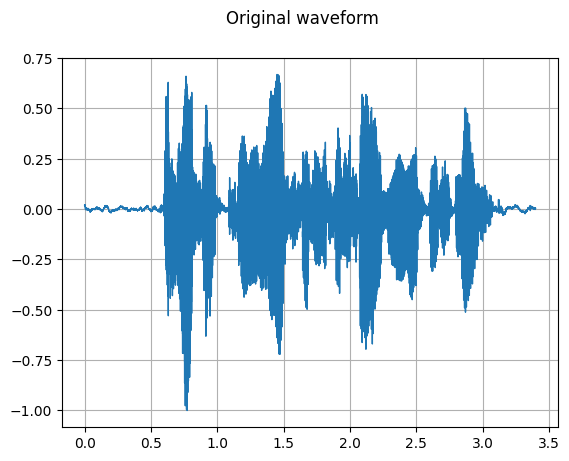

In [ ]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title='Original waveform')
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
)

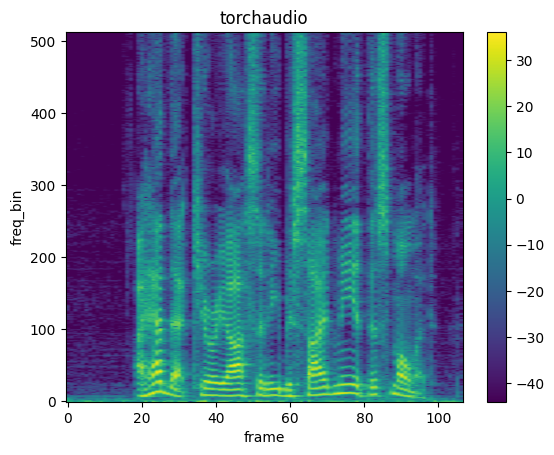

In [ ]:
spec = spectrogram(SPEECH_WAVEFORM)
plot_spectrogram(spec[0], title='torchaudio')

In [ ]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_SPEECH)
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

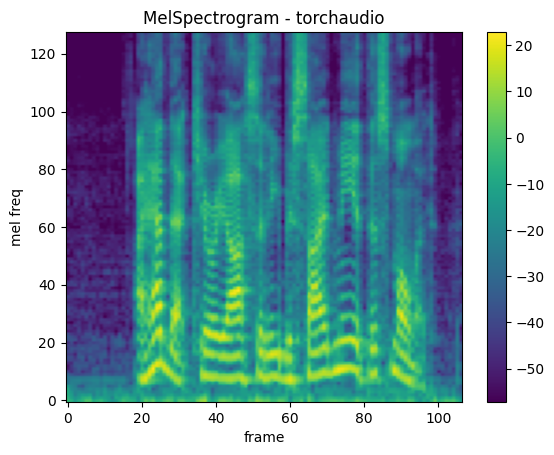

In [ ]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

**Librosa**

In [ ]:
y, sr = librosa.load(SAMPLE_SPEECH)

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    y = y,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

In [ ]:
print(melspec_librosa.mean())
print(melspec.mean())

3.5519626
tensor(0.9912)


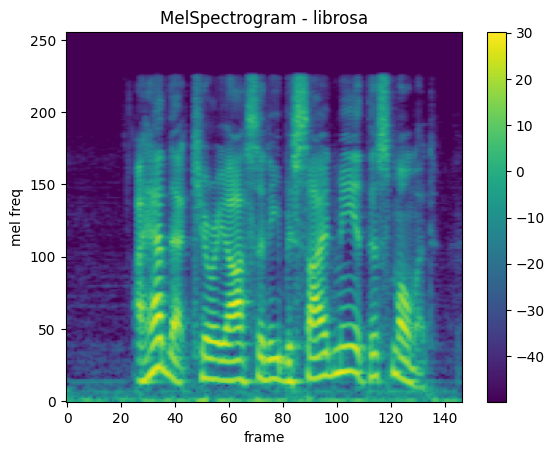

Mean Square Difference:  6.557559350270115


In [ ]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = (melspec.mean().item() - melspec_librosa.mean().item()) **2
print('Mean Square Difference: ', mse)

MFCC

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

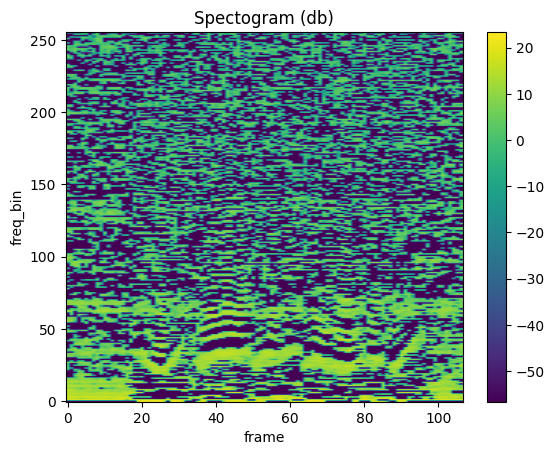

In [ ]:
plot_spectrogram(mfcc[0])

Comparison against librosa

In [ ]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

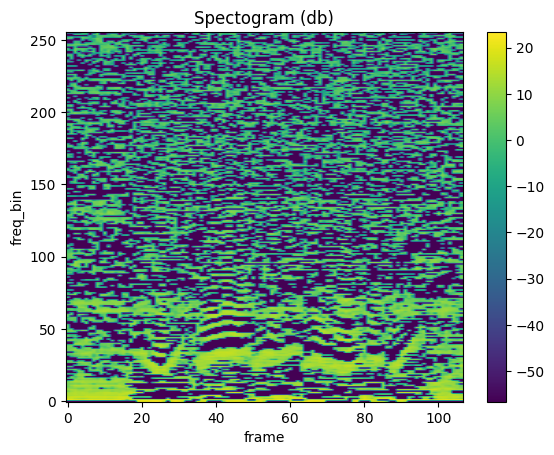

Mean Square Difference:  1.0665754079818726


In [ ]:
plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)